## 9.1 MNIST

* train-images-idx3-ubyte.gz:  training set images (9912422 bytes)   
* train-labels-idx1-ubyte.gz:  training set labels (28881 bytes)  
* t10k-images-idx3-ubyte.gz:   test set images (1648877 bytes)  
* t10k-labels-idx1-ubyte.gz:   test set labels (4542 bytes) 

### 9.1.1 训练集的标记文件

### 9.1.2 训练集的图片文件

### 9.1.3 测试集的标记文件

### 9.1.3 测试集的图片文件

## 9.2 MNIST 的分类问题

### 9.2.1 加载数据

In [9]:
import argparse
import sys

from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf
data_dir = "tmp/tensorflow/mnist/input_data"

mnist = input_data.read_data_sets(data_dir, one_hot=True)

Extracting tmp/tensorflow/mnist/input_data/train-images-idx3-ubyte.gz
Extracting tmp/tensorflow/mnist/input_data/train-labels-idx1-ubyte.gz
Extracting tmp/tensorflow/mnist/input_data/t10k-images-idx3-ubyte.gz
Extracting tmp/tensorflow/mnist/input_data/t10k-labels-idx1-ubyte.gz


### 9.2.2 构建回归模型

In [16]:
x = tf.placeholder(tf.float32, [None, 784])
W = tf.Variable(tf.zeros([784, 10]))
b = tf.Variable(tf.zeros([10]))
y = tf.matmul(x, W) + b

In [17]:
# 定义损失函数和优化器
y_ = tf.placeholder(tf.float32, [None, 10])
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y, labels=y_))
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

### 9.2.3 训练模型

In [18]:
# 这里使用InteractiveSession()来创建交互式上下文的TensorFlow会话
# 与常规会话不同的是，交互式会话会成为默认会话
# 方法（如tf.Tensor.eval和tf.Operation.run)都可以使用该会话来运行操作(OP)
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

In [20]:
# Train
for _ in range(1000):
    batch_xs, batch_ys = mnist.train.next_batch(100)
    sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys})

### 9.2.4 评估模型

In [25]:
# 评估训练好的模型
correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1)) # 计算预测值和真实值
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print(sess.run(accuracy, feed_dict={x: mnist.test.images, y_: mnist.test.labels}))

0.9186


## 9.3 训练过程的可视化

In [27]:
def variable_summaries(var):
    """对一个张量添加多个摘要描述"""
    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.summary.scalar('mean', mean) # 均值
        with tf.name_scope('stddev'):
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
        tf.summary.scalar('stddev', stddev) # 标准差
        tf.summary.scalar('max', tf.reduce_max(var))
        tf.summary.scalar('min', tf.reduce_min(var))
        tf.summary.histogram('histogram', var)

## 9.4 MNIST 的卷积神经网络

### 9.4.1 加载数据

In [28]:
import tensorflow as tf
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data

### 9.4.2 构建模型

In [29]:
trX, trY, teX, teY = mnist.train.images, mnist.train.labels, mnist.test.images, mnist.test.labels

(1)数据预处理

In [32]:
trX = trX.reshape(-1, 28, 28, 1)
teX = teX.reshape(-1, 28, 28, 1)
X = tf.placeholder("float", [None, 28, 28, 1])
Y = tf.placeholder("float", [None, 10])

(2)初始化权重与定义网络结构

In [33]:
def init_weights(shape):
    return tf.Variable(tf.random_normal(shape, stddev=0.01))

w = init_weights([3, 3, 1, 32])
w2 = init_weights([3, 3, 32, 64])
w3 = init_weights([3, 3, 64, 128])
w4 = init_weights([128 * 4 * 4, 625])
w_o = init_weights([625, 10])

In [42]:
# 神经网络模型的构建函数，传入以下参数
    # X: 输入数据
    # w: 每一层的权重
    # p_keep_conv, p_keep_hidden: dropout 要保存的神经元比例
    
def model(X, w, w2, w3, w4, w_o, p_keep_conv, p_keep_hidden):
    # 第一组卷积层及池化层，最后dropout一些神经元
    l1a = tf.nn.relu(tf.nn.conv2d(X, w, strides=[1, 1, 1, 1], padding='SAME'))
    # l1a shape=(?, 28, 28, 32)
    l1 = tf.nn.max_pool(l1a, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    # l1 shape=(?, 14, 14, 32)
    l1 = tf.nn.dropout(l1, p_keep_conv)
    
    # 第二组卷积层及池化层，最后dropout一些神经元
    l2a = tf.nn.relu(tf.nn.conv2d(l1, w2, strides=[1, 1, 1, 1], padding='SAME'))
    # l2a shape=(?, 14, 14, 64)
    l2 = tf.nn.max_pool(l2a, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    # l2 shape=(?, 7, 7, 64)
    l2 = tf.nn.dropout(l2, p_keep_conv)
    
    # 第三组卷积层及池化层，最后dropout一些神经元
    l3a = tf.nn.relu(tf.nn.conv2d(l2, w3, strides=[1, 1, 1, 1], padding='SAME'))
    # l3a shape=(?, 7, 7, 128)
    l3 = tf.nn.max_pool(l3a, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    # l3 shape=(?, 4, 4, 128)
    l3 = tf.reshape(l3, [-1, w4.get_shape().as_list()[0]]) # reshape to (?, 2048)
    l3 = tf.nn.dropout(l3, p_keep_conv)
    
    # 全连接层，最后dropout一些神经元
    l4 = tf.nn.relu(tf.matmul(l3, w4))
    l4 = tf.nn.dropout(l4, p_keep_hidden)
    
    # 输出层
    pyx = tf.matmul(l4, w_o)
    return pyx

In [43]:
p_keep_conv = tf.placeholder("float")
p_keep_hidden = tf.placeholder("float")
py_x = model(X, w, w2, w3, w4, w_o, p_keep_conv, p_keep_hidden)

In [44]:
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=py_x, labels=Y))
train_op = tf.train.RMSPropOptimizer(0.001, 0.9).minimize(cost)
predict_op = tf.argmax(py_x, 1)

### 9.4.3 训练模型和评估模型

In [45]:
batch_size = 128
test_size = 256

In [47]:
# Lauch the graph in a session
with tf.Session() as sess:
    # you need to initialize all variables
    tf.global_variables_initializer().run()
    
    for i in range(100):
        training_batch = zip(range(0, len(trX), batch_size), range(batch_size, len(trX)+1, batch_size))
        for start, end in training_batch:
            sess.run(train_op, feed_dict={X: trX[start:end], Y: trY[start:end], p_keep_conv: 0.8, p_keep_hidden: 0.5})
            
        test_indices = np.arange(len(teX))
        np.random.shuffle(test_indices)
        test_indices = test_indices[0:test_size]
        print(i, np.mean(np.argmax(teY[test_indices], axis=1) ==
                            sess.run(predict_op, feed_dict={X: teX[test_indices],
                                                           p_keep_conv: 1.0,
                                                           p_keep_hidden: 1.0})))

(0, 0.96484375)
(1, 0.984375)
(2, 0.9921875)
(3, 0.9921875)
(4, 0.984375)


KeyboardInterrupt: 

## 9.5 MNIST 的循环神经网络

### 9.5.1 加载数据

### 9.5.2 构建模型

In [78]:
from tensorflow.contrib import rnn
# 设置训练的超参数
# Training Parameters
learning_rate = 0.001
training_steps = 10000
batch_size = 128
display_step = 200

In [64]:
# 神经网络的参数
num_input = 28 # 输入层的n
timesteps = 28 # 28 长度
num_hidden = 128 # 隐藏层的神经元个数
num_classes = 10 # 输出的数量，即分类的类别，0~9个数字，共有10个

In [72]:
# 输入数据占位符
X = tf.placeholder(tf.float32, [None, timesteps, num_input])
Y = tf.placeholder(tf.float32, [None, num_classes])

In [73]:
# 定义权重
weights = {
    # (28, 128)
#     'in': tf.Variable(tf.random_normal([num_input, num_hidden])),
    # (128, 10)
    'out': tf.Variable(tf.random_normal([num_hidden, num_classes]))
}

biases = {
    # (128, )
#     'in': tf.Variable(tf.constant(0.1, shape=[num_hidden, ])),
    # (10, )
    'out': tf.Variable(tf.constant(0.1, shape=[num_classes, ]))
}

In [74]:
def RNN(x, weights, biases):
    # 把输入的X转换成X 
    # Unstack to get a list of 'timesteps' tensors of shape (batch_size, n_input)
    x = tf.unstack(x, timesteps, 1)
    # Define a lstm cell with tensorflow
    lstm_cell = rnn.BasicLSTMCell(num_hidden, forget_bias=1.0)
    # Get lstm cell output
    outputs, states = rnn.static_rnn(lstm_cell, x, dtype=tf.float32)
    # Linear activation, using rnn inner loop last output
    return tf.matmul(outputs[-1], weights['out']) + biases['out']

In [75]:
# 定义损失函数和优化器，优化器采用AdamOptimizer
logits = RNN(X, weights, biases)
prediction = tf.nn.softmax(logits)

# Define loss and optimizer
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
    logits=logits, labels=Y))
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)

In [76]:
# 定义模型预测结果及准确率计算方法：
correct_pred = tf.equal(tf.argmax(prediction, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

### 9.5.3 训练数据及评估模型

In [79]:
init = tf.global_variables_initializer()
# Start training
with tf.Session() as sess:

    # Run the initializer
    sess.run(init)

    for step in range(1, training_steps+1):
        batch_x, batch_y = mnist.train.next_batch(batch_size)
        # Reshape data to get 28 seq of 28 elements
        batch_x = batch_x.reshape((batch_size, timesteps, num_input))
        # Run optimization op (backprop)
        sess.run(train_op, feed_dict={X: batch_x, Y: batch_y})
        if step % display_step == 0 or step == 1:
            # Calculate batch loss and accuracy
            loss, acc = sess.run([loss_op, accuracy], feed_dict={X: batch_x,
                                                                 Y: batch_y})
            print("Step " + str(step) + ", Minibatch Loss= " + \
                  "{:.4f}".format(loss) + ", Training Accuracy= " + \
                  "{:.3f}".format(acc))

    print("Optimization Finished!")

    # Calculate accuracy for 128 mnist test images
    test_len = 128
    test_data = mnist.test.images[:test_len].reshape((-1, timesteps, num_input))
    test_label = mnist.test.labels[:test_len]
    print("Testing Accuracy:", \
        sess.run(accuracy, feed_dict={X: test_data, Y: test_label}))

Step 1, Minibatch Loss= 2.4616, Training Accuracy= 0.109
Step 200, Minibatch Loss= 2.1283, Training Accuracy= 0.320
Step 400, Minibatch Loss= 1.9810, Training Accuracy= 0.344
Step 600, Minibatch Loss= 1.8088, Training Accuracy= 0.461
Step 800, Minibatch Loss= 1.6978, Training Accuracy= 0.469
Step 1000, Minibatch Loss= 1.5790, Training Accuracy= 0.523
Step 1200, Minibatch Loss= 1.5767, Training Accuracy= 0.508
Step 1400, Minibatch Loss= 1.4004, Training Accuracy= 0.555
Step 1600, Minibatch Loss= 1.4327, Training Accuracy= 0.555
Step 1800, Minibatch Loss= 1.4280, Training Accuracy= 0.531
Step 2000, Minibatch Loss= 1.2167, Training Accuracy= 0.617
Step 2200, Minibatch Loss= 1.1308, Training Accuracy= 0.688
Step 2400, Minibatch Loss= 1.1683, Training Accuracy= 0.648
Step 2600, Minibatch Loss= 1.1565, Training Accuracy= 0.656
Step 2800, Minibatch Loss= 0.9870, Training Accuracy= 0.719
Step 3000, Minibatch Loss= 0.9740, Training Accuracy= 0.703
Step 3200, Minibatch Loss= 1.0897, Training Acc

## 9.6 MNIST 的无监督模型

### 9.6.1 自编码网络

### 9.6.2 TensorFlow 的自编码网络实现

1.加载数据

In [92]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data

2.构建模型

In [82]:
# 设置训练超参数
learning_rate = 0.01
num_steps = 30000
batch_size = 256

display_step = 1000
examples_to_show = 10

In [83]:
# 网络参数
num_hidden_1 = 256 # 1st layer num features
num_hidden_2 = 128 # 2nd layer num features (the latent dim)
num_input = 784 # MNIST data input (img shape: 28*28)

In [84]:
# 初始化每一层的权重和偏置
X = tf.placeholder("float", [None, num_input])

weights = {
    'encoder_h1': tf.Variable(tf.random_normal([num_input, num_hidden_1])),
    'encoder_h2': tf.Variable(tf.random_normal([num_hidden_1, num_hidden_2])),
    'decoder_h1': tf.Variable(tf.random_normal([num_hidden_2, num_hidden_1])),
    'decoder_h2': tf.Variable(tf.random_normal([num_hidden_1, num_input])),
}
biases = {
    'encoder_b1': tf.Variable(tf.random_normal([num_hidden_1])),
    'encoder_b2': tf.Variable(tf.random_normal([num_hidden_2])),
    'decoder_b1': tf.Variable(tf.random_normal([num_hidden_1])),
    'decoder_b2': tf.Variable(tf.random_normal([num_input])),
}

In [86]:
# 定义压缩函数
def encoder(x):
    # Encoder Hidden layer with sigmoid activation #1
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['encoder_h1']),
                                   biases['encoder_b1']))
    # Encoder Hidden layer with sigmoid activation #2
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['encoder_h2']),
                                   biases['encoder_b2']))
    return layer_2

In [87]:
# 定义解压函数
def decoder(x):
    # Decoder Hidden layer with sigmoid activation #1
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['decoder_h1']),
                                   biases['decoder_b1']))
    # Decoder Hidden layer with sigmoid activation #2
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['decoder_h2']),
                                   biases['decoder_b2']))
    return layer_2

In [88]:
# 构建模型
encoder_op = encoder(X)
decoder_op = decoder(encoder_op)

In [89]:
# 得出预测值
y_pred = decoder_op
# 得出真实值，即输入值
y_true = X

In [90]:
# 定义损失函数和优化器
loss = tf.reduce_mean(tf.pow(y_true - y_pred, 2))
optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(loss)

3.训练数据及评估模型

Step 1: Minibatch Loss: 0.443267
Step 1000: Minibatch Loss: 0.131007
Step 2000: Minibatch Loss: 0.109948
Step 3000: Minibatch Loss: 0.103132
Step 4000: Minibatch Loss: 0.096126
Step 5000: Minibatch Loss: 0.090409
Step 6000: Minibatch Loss: 0.083909
Step 7000: Minibatch Loss: 0.081003
Step 8000: Minibatch Loss: 0.079977
Step 9000: Minibatch Loss: 0.078899
Step 10000: Minibatch Loss: 0.077930
Step 11000: Minibatch Loss: 0.078099
Step 12000: Minibatch Loss: 0.078490
Step 13000: Minibatch Loss: 0.076607
Step 14000: Minibatch Loss: 0.072707
Step 15000: Minibatch Loss: 0.071829
Step 16000: Minibatch Loss: 0.070167
Step 17000: Minibatch Loss: 0.068610
Step 18000: Minibatch Loss: 0.066308
Step 19000: Minibatch Loss: 0.066126
Step 20000: Minibatch Loss: 0.065474
Step 21000: Minibatch Loss: 0.066011
Step 22000: Minibatch Loss: 0.062848
Step 23000: Minibatch Loss: 0.063744
Step 24000: Minibatch Loss: 0.062377
Step 25000: Minibatch Loss: 0.062942
Step 26000: Minibatch Loss: 0.060968
Step 27000: Mi

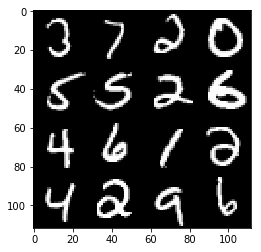

Reconstructed Images


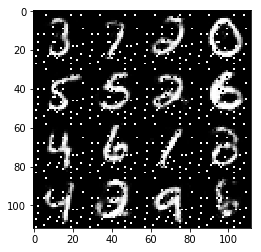

In [93]:
# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

# Start Training
# Start a new TF session
with tf.Session() as sess:

    # Run the initializer
    sess.run(init)

    # Training
    for i in range(1, num_steps+1):
        # Prepare Data
        # Get the next batch of MNIST data (only images are needed, not labels)
        batch_x, _ = mnist.train.next_batch(batch_size)

        # Run optimization op (backprop) and cost op (to get loss value)
        _, l = sess.run([optimizer, loss], feed_dict={X: batch_x})
        # Display logs per step
        if i % display_step == 0 or i == 1:
            print('Step %i: Minibatch Loss: %f' % (i, l))

    # Testing
    # Encode and decode images from test set and visualize their reconstruction.
    n = 4
    canvas_orig = np.empty((28 * n, 28 * n))
    canvas_recon = np.empty((28 * n, 28 * n))
    for i in range(n):
        # MNIST test set
        batch_x, _ = mnist.test.next_batch(n)
        # Encode and decode the digit image
        g = sess.run(decoder_op, feed_dict={X: batch_x})

        # Display original images
        for j in range(n):
            # Draw the original digits
            canvas_orig[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = \
                batch_x[j].reshape([28, 28])
        # Display reconstructed images
        for j in range(n):
            # Draw the reconstructed digits
            canvas_recon[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = \
                g[j].reshape([28, 28])

    print("Original Images")
    plt.figure(figsize=(n, n))
    plt.imshow(canvas_orig, origin="upper", cmap="gray")
    plt.show()

    print("Reconstructed Images")
    plt.figure(figsize=(n, n))
    plt.imshow(canvas_recon, origin="upper", cmap="gray")
    plt.show()